In [1]:
import torch
from pathlib import Path
import requests

### Downloading the MNIST dataset

In [2]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"
PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

In [3]:
if not (PATH / FILENAME).exists(): 
    # download it 
    content = requests.get(URL + FILENAME).content
    # write it inside folder
    (PATH / FILENAME).open("wb").write(content)

In [4]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [5]:
import matplotlib.pyplot as plt 
import numpy as np

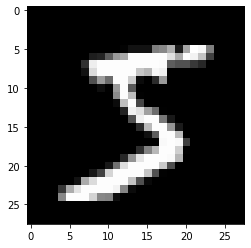

In [6]:
image = x_train[0].reshape((28,28)) 
plt.imshow(image, cmap="gray")

### converting numpy arrays to tensors  

In [7]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, [x_train, y_train, x_valid, y_valid])

In [8]:
print(type(x_train[0]))
print(x_train[0].dtype)

<class 'torch.Tensor'>
torch.float32


In [9]:
# xavier init
weights_0 = torch.randn(784, 10) / np.sqrt(784)
# record ops who are using the tensor , for back prop 
weights_0.requires_grad_()
biais_0 = torch.zeros(10, requires_grad=True) 

weights_1 = torch.randn(10,10) / np.sqrt(10) 
weights_1.requires_grad_() 
biais_1 = torch.zeros(10, requires_grad=True)

In [10]:
import math
def log_softmax(z): 
    return z - z.exp().sum(-1).log().unsqueeze(-1)
    
def relu(z): 
    z[z<0] = 0
    return z

def model(inputs): 
    a1 = relu(inputs @ weights_0 + biais_0) 
    a2 = log_softmax(a1 @ weights_1 + biais_1)
    
    return a2


In [11]:
batch_size = 12 

samples = x_train[:12] 
preds = model(samples) 
preds[0]

tensor([-2.5413, -2.5696, -2.2639, -2.5594, -2.2920, -2.1553, -2.5200, -2.0364,
        -2.2337, -2.0531], grad_fn=<SelectBackward0>)

In [12]:
y = y_train[:batch_size]
print(y.shape)
print(preds.shape)

torch.Size([12])
torch.Size([12, 10])


In [13]:
def negative_log_likelihood(input, target): 
    return -input[range(target.shape[0]), target].mean()

In [14]:
preds[[0],0]

tensor([-2.5413], grad_fn=<IndexBackward0>)

In [15]:
negative_log_likelihood(preds, y)

tensor(2.3597, grad_fn=<NegBackward0>)

In [16]:
def accuracy(y_pred, y_true): 
    cls = torch.argmax(y_pred, dim=1) 
    return torch.where(y_true == cls, 1, 0).float().mean()

In [17]:
accuracy(preds, y)

tensor(0.)

### writing a training loop 

<p>loss.backward() updates the gradients of the model, in this case, weights and bias.</p>

In [18]:
lr = 0.1
epochs = 2 
nb_batch = (len(x_train)-1) // batch_size + 1

for i in range(epochs): 
    for batch in range(nb_batch): 
        start = batch * batch_size 
        end = start + batch_size
        
        x_batch = x_train[start:end]
        y_batch = y_train[start:end] 
        
        preds = model(x_batch) 
        loss = negative_log_likelihood(preds, y_train[start:end]) 
        
        # compute loss grad wrt to model parameters
        loss.backward() 
        
        with torch.no_grad(): # Context-manager that disabled gradient calculation
            # we are cancelling the grad computation when modifying our parameters 
            weights_0 -= weights_0.grad * lr 
            biais_0 -= biais_0.grad * lr
            weights_1 -= weights_1.grad * lr 
            biais_1 -= biais_1.grad * lr
            
            # reset gradients regarding parameters
            weights_0.grad.zero_()
            weights_1.grad.zero_()
            biais_0.grad.zero_()
            biais_1.grad.zero_()

In [19]:
print("loss", negative_log_likelihood(model(x_train[:12]), y_train[:12]))

loss tensor(0.1516, grad_fn=<NegBackward0>)


In [20]:
accuracy(model(x_train[:12]), y_train[:12])

tensor(0.9167)

### Refactor using nn.Module

In [29]:
from torch import nn 
import torch.nn.functional as F

loss_func = F.cross_entropy
class MnistNet(nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(784, 10) / np.sqrt(784))
        self.biais = nn.Parameter(torch.zeros(10))
        
    def forward(self, x): 
        return x @ self.weights + self.biais

In [30]:
model = MnistNet()

In [31]:
def fit(): 
    for epoch in range(epochs): 
        for i in range((x_train.shape[0] -1) // batch_size + 1): 
            start = i*batch_size
            end = i*batch_size + batch_size 
            
            x_batch = x_train[start:end] 
            y_batch = y_train[start:end] 
            
            pred = model(x_batch) 
            loss = loss_func(pred, y_batch) 
            
            #backprop
            loss.backward() 
            
            with torch.no_grad(): 
                for p in model.parameters(): 
                    p -= p.grad * lr
                # reset the gradient regarding each parameters
                model.zero_grad()
                

In [32]:
fit()

In [33]:
loss_func(model(x_train[:12]), y_train[:12])

tensor(0.0746, grad_fn=<NllLossBackward0>)

### Refactoring using linear 

In [34]:
# linear layer does a@w + b

In [ ]:
class MnistNet(nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.linear = nn.Linear(784, 10)
        
    def forward(self, x): 
        return x @ self.weights + self.biais